**Section 1: Dataset Loading and Visualization**


In [ ]:
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

dataset_path = "/content/drive/MyDrive/weather classification"


🧭 Total Classes Found: 11
Classes: ['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']


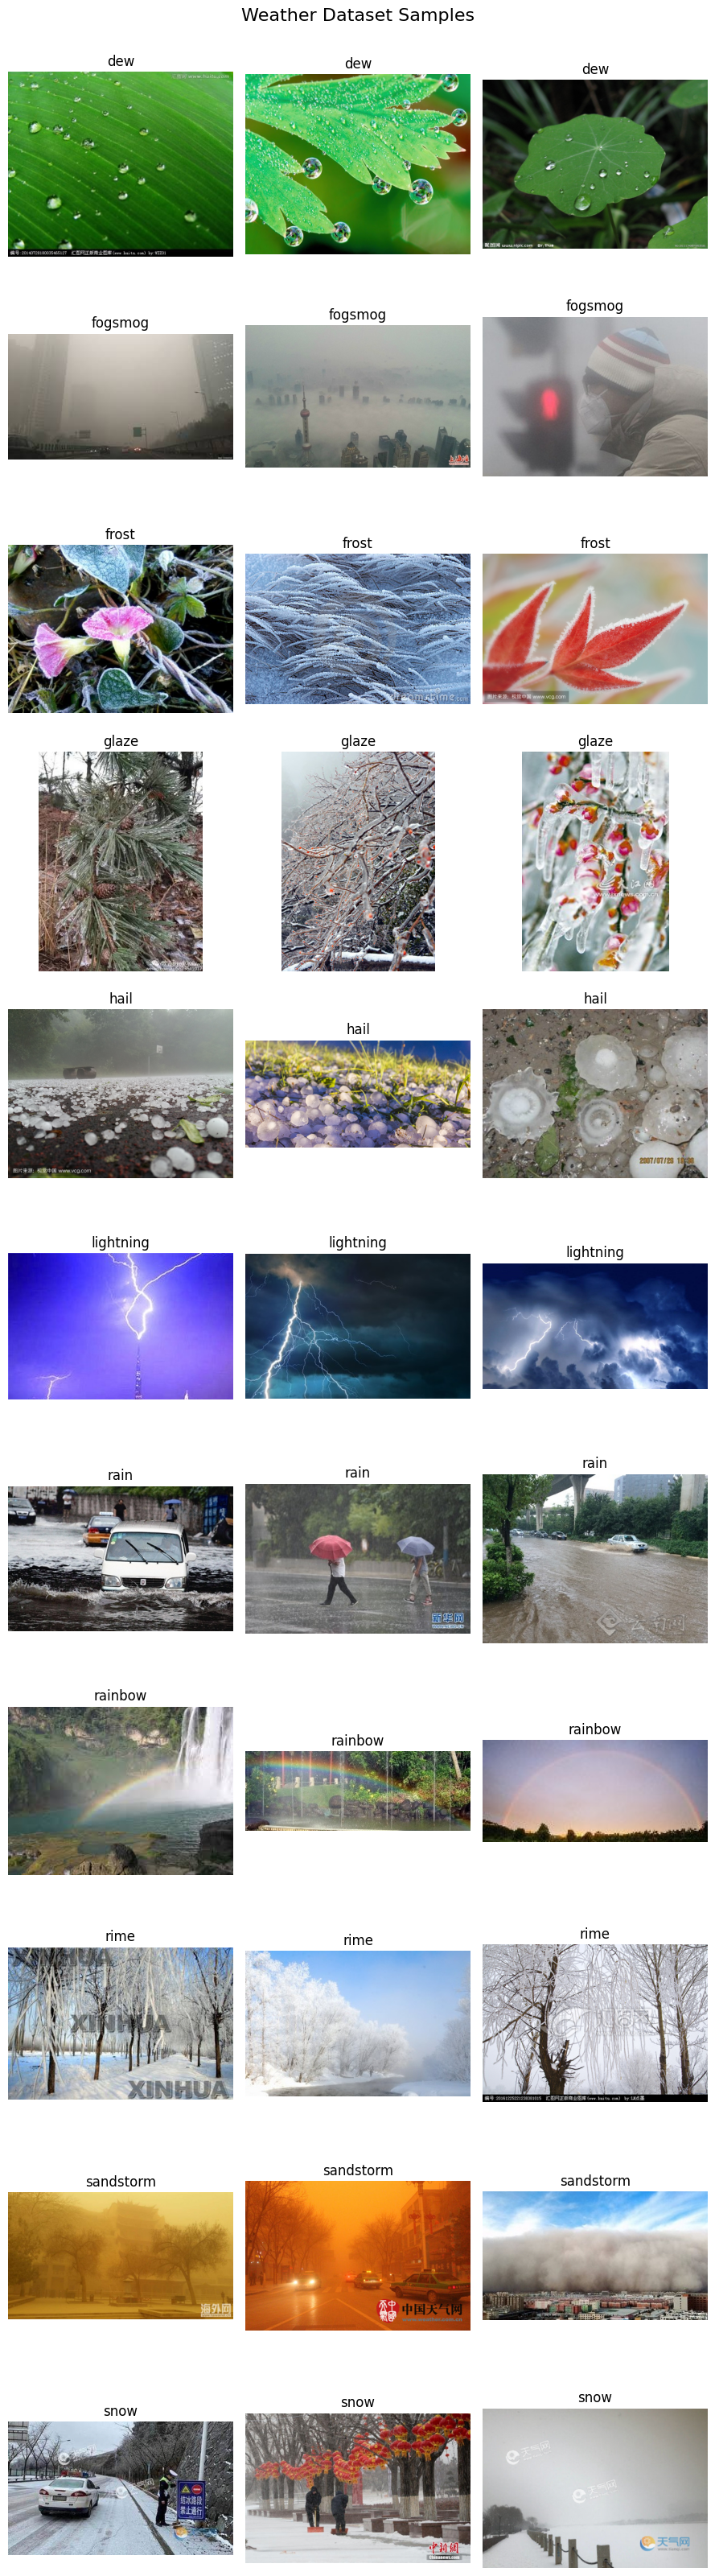

In [ ]:
import random
import matplotlib.pyplot as plt
from PIL import Image

def load_and_display_weather_images(dataset_path, samples_per_class=3):
    """
    Loads weather images from a directory and displays 2–3 random images from each class.

    Args:
        dataset_path (str): Path to the root dataset directory.
        samples_per_class (int): Number of random samples per class to display.
    """
    classes = sorted([d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))])
    print(f"🧭 Total Classes Found: {len(classes)}")
    print("Classes:", classes)

    fig, axs = plt.subplots(len(classes), samples_per_class, figsize=(samples_per_class * 3, len(classes) * 3))
    fig.suptitle('Weather Dataset Samples', fontsize=16)

    for i, class_name in enumerate(classes):
        class_dir = os.path.join(dataset_path, class_name)
        images = [img for img in os.listdir(class_dir) if img.endswith(('.jpg', '.png', '.jpeg'))]

        selected_images = random.sample(images, min(samples_per_class, len(images)))

        for j, img_name in enumerate(selected_images):
            img_path = os.path.join(class_dir, img_name)
            img = Image.open(img_path).convert('RGB')
            ax = axs[i, j] if samples_per_class > 1 else axs[i]
            ax.imshow(img)
            ax.set_title(f"{class_name}")
            ax.axis('off')

        for k in range(len(selected_images), samples_per_class):
            ax = axs[i, k] if samples_per_class > 1 else axs[i]
            ax.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

# Run the function
load_and_display_weather_images(dataset_path, samples_per_class=3)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


**Section 2: Data Preprocessing**


In [ ]:
import os
import shutil
import random
from tqdm import tqdm

# Your original dataset folder
ORIG_DATASET_DIR = dataset_path       # must contain class folders
BASE_OUTPUT_DIR = 'dataset'             # will contain train/val/test

# Ratios for splitting
TRAIN_RATIO = 0.7
VAL_RATIO = 0.2
TEST_RATIO = 0.1

random.seed(42)

splits = ['train', 'val', 'test']

# Create base folders
for split in splits:
    os.makedirs(os.path.join(BASE_OUTPUT_DIR, split), exist_ok=True)

# Get class folders
classes = [cls for cls in os.listdir(ORIG_DATASET_DIR)
           if os.path.isdir(os.path.join(ORIG_DATASET_DIR, cls))]

for cls in tqdm(classes, desc="Processing classes"):
    class_path = os.path.join(ORIG_DATASET_DIR, cls)
    images = [f for f in os.listdir(class_path)
              if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    random.shuffle(images)

    n_total = len(images)
    n_train = int(n_total * TRAIN_RATIO)
    n_val = int(n_total * VAL_RATIO)

    split_images = {
        'train': images[:n_train],
        'val': images[n_train:n_train + n_val],
        'test': images[n_train + n_val:]
    }

    for split in splits:
        split_cls_dir = os.path.join(BASE_OUTPUT_DIR, split, cls)
        os.makedirs(split_cls_dir, exist_ok=True)

        for fname in split_images[split]:
            src = os.path.join(class_path, fname)
            dst = os.path.join(split_cls_dir, fname)
            shutil.copy2(src, dst)


Processing classes: 100%|██████████| 11/11 [00:40<00:00,  3.66s/it]


In [ ]:
base_dir = 'dataset'
for split in ['train', 'val', 'test']:
    print(f"\nChecking {split} set:")
    path = os.path.join(base_dir, split)
    for cls in os.listdir(path):
        cls_path = os.path.join(path, cls)
        if os.path.isdir(cls_path):
            img_count = len([f for f in os.listdir(cls_path)
                             if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
            print(f"{cls}: {img_count} images")



Checking train set:
hail: 413 images
glaze: 453 images
snow: 434 images
sandstorm: 484 images
rainbow: 162 images
lightning: 264 images
frost: 332 images
dew: 488 images
fogsmog: 595 images
rain: 368 images
rime: 812 images

Checking val set:
hail: 118 images
glaze: 129 images
snow: 124 images
sandstorm: 138 images
rainbow: 46 images
lightning: 75 images
frost: 95 images
dew: 139 images
fogsmog: 170 images
rain: 105 images
rime: 232 images

Checking test set:
hail: 60 images
glaze: 66 images
snow: 63 images
sandstorm: 70 images
rainbow: 24 images
lightning: 39 images
frost: 48 images
dew: 71 images
fogsmog: 86 images
rain: 53 images
rime: 116 images


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SIZE = (128, 128)
BATCH_SIZE = 32

# Augment training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

# Validation and test data: only rescaling
test_val_datagen = ImageDataGenerator(rescale=1./255)

# Generators
train_generator = train_datagen.flow_from_directory(
    'dataset/train',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = test_val_datagen.flow_from_directory(
    'dataset/val',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_val_datagen.flow_from_directory(
    'dataset/test',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 4805 images belonging to 11 classes.
Found 1371 images belonging to 11 classes.
Found 696 images belonging to 11 classes.


**Section 3: Model Building**


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam  # or RMSprop


In [ ]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Input(shape=(*IMAGE_SIZE, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(train_generator.num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 11)             │         1,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,306,059 (12.61 MB)

 Trainable params: 3,306,059 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

**Section 4: Training and Evaluation**


In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5
)



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
151/151 ━━━━━━━━━━━━━━━━━━━━ 50s 298ms/step - accuracy: 0.3791 - loss: 1.8316 - val_accuracy: 0.5259 - val_loss: 1.4184
Epoch 2/5
151/151 ━━━━━━━━━━━━━━━━━━━━ 40s 263ms/step - accuracy: 0.5782 - loss: 1.2493 - val_accuracy: 0.6360 - val_loss: 1.0864
Epoch 3/5
151/151 ━━━━━━━━━━━━━━━━━━━━ 40s 264ms/step - accuracy: 0.6398 - loss: 1.0704 - val_accuracy: 0.6156 - val_loss: 1.1161
Epoch 4/5
151/151 ━━━━━━━━━━━━━━━━━━━━ 40s 263ms/step - accuracy: 0.6435 - loss: 1.0602 - val_accuracy: 0.6761 - val_loss: 0.9505
Epoch 5/5
151/151 ━━━━━━━━━━━━━━━━━━━━ 40s 263ms/step - accuracy: 0.6766 - loss: 0.9615 - val_accuracy: 0.6776 - val_loss: 0.9423


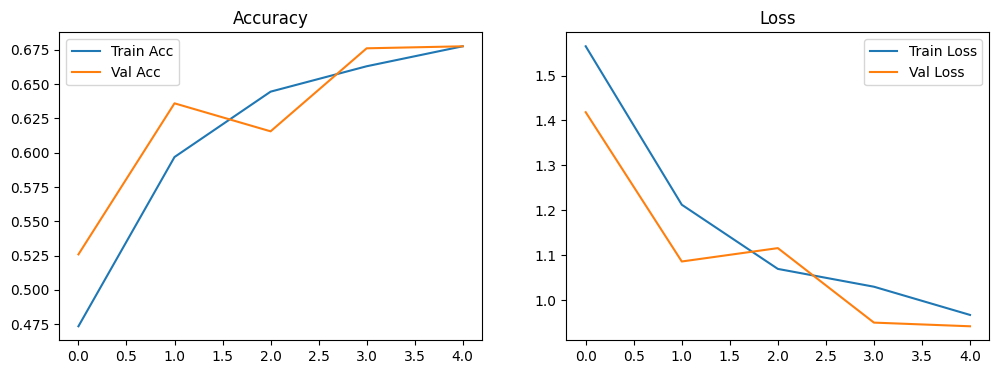

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.show()



In [ ]:
# Classification report and Confusion Matrix
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

y_true = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis=1)

print("Classification Report:\n", classification_report(y_true, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))


22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.68      0.77        71
           1       0.81      0.73      0.77        86
           2       0.39      0.67      0.49        48
           3       0.43      0.39      0.41        66
           4       0.72      0.60      0.65        60
           5       0.72      0.97      0.83        39
           6       0.77      0.51      0.61        53
           7       0.73      0.79      0.76        24
           8       0.79      0.83      0.81       116
           9       0.82      0.87      0.85        70
          10       0.66      0.63      0.65        63

    accuracy                           0.70       696
   macro avg       0.70      0.70      0.69       696
weighted avg       0.72      0.70      0.70       696

Confusion Matrix:
 [[48  0  2  8  6  3  0  1  2  1  0]
 [ 0 63  0  1  1  4  2  1  1 11  2]
 [ 4  0 32  6  1  0  2  0  2  0

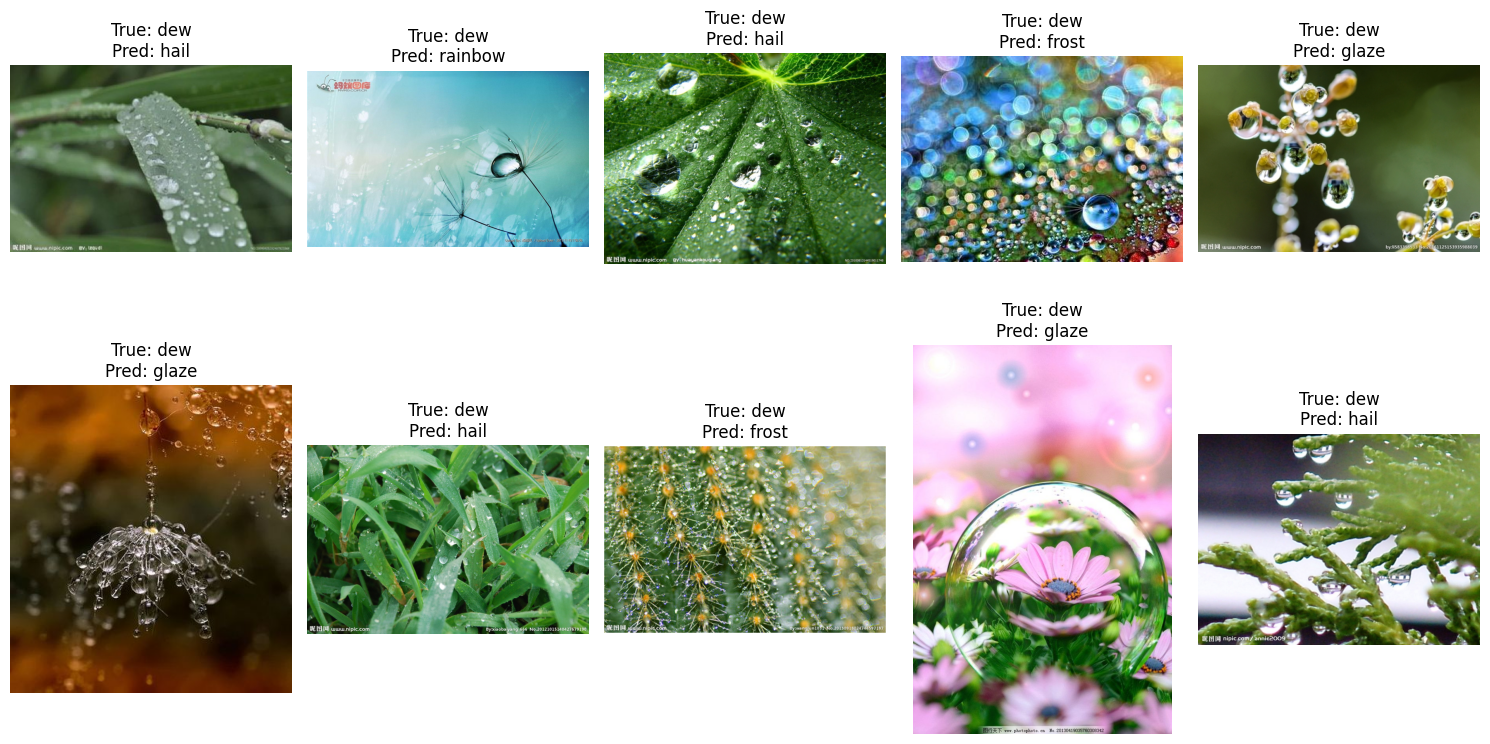

In [ ]:
# misclassified images with their predicted vs actual labels.

import matplotlib.pyplot as plt

class_labels = list(test_generator.class_indices.keys())
filenames = test_generator.filenames

misclassified_idx = np.where(y_pred != y_true)[0]

plt.figure(figsize=(15, 8))
for i, idx in enumerate(misclassified_idx[:10]):
    img_path = os.path.join('dataset/test', filenames[idx])
    img = plt.imread(img_path)
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(f"True: {class_labels[y_true[idx]]}\nPred: {class_labels[y_pred[idx]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


**Section 5: Model Improvement**


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os


IMAGE_SIZE_TRANSFER = (224, 224)
BATCH_SIZE = 32

# Augment training data
train_datagen_transfer = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

# Validation and test data: only rescaling (adjust target_size)
test_val_datagen_transfer = ImageDataGenerator(rescale=1./255)

# Updated Generators with the new target_size
train_generator_transfer = train_datagen_transfer.flow_from_directory(
    'dataset/train',
    target_size=IMAGE_SIZE_TRANSFER,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator_transfer = test_val_datagen_transfer.flow_from_directory(
    'dataset/val',
    target_size=IMAGE_SIZE_TRANSFER,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_tensor=Input(shape=(*IMAGE_SIZE_TRANSFER, 3))
)

# Freeze base layers
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)

num_classes = train_generator_transfer.num_classes
predictions = Dense(num_classes, activation='softmax')(x)

model_transfer = Model(inputs=base_model.input, outputs=predictions)

model_transfer.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Fit the model using the new generators
history_transfer = model_transfer.fit(
    train_generator_transfer,
    validation_data=val_generator_transfer,
    epochs=10
)

Found 4805 images belonging to 11 classes.
Found 1371 images belonging to 11 classes.


<ipython-input-37-4cabb5e2f35c>:54: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_169']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


151/151 ━━━━━━━━━━━━━━━━━━━━ 105s 623ms/step - accuracy: 0.4619 - loss: 1.6068 - val_accuracy: 0.7717 - val_loss: 0.6439
Epoch 2/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 95s 632ms/step - accuracy: 0.7305 - loss: 0.7734 - val_accuracy: 0.7914 - val_loss: 0.6117
Epoch 3/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 81s 536ms/step - accuracy: 0.7591 - loss: 0.6795 - val_accuracy: 0.8045 - val_loss: 0.5585
Epoch 4/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 79s 526ms/step - accuracy: 0.7770 - loss: 0.6242 - val_accuracy: 0.8133 - val_loss: 0.5357
Epoch 5/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 80s 532ms/step - accuracy: 0.7749 - loss: 0.6166 - val_accuracy: 0.8206 - val_loss: 0.5099
Epoch 6/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 79s 525ms/step - accuracy: 0.7957 - loss: 0.5670 - val_accuracy: 0.8031 - val_loss: 0.5501
Epoch 7/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 80s 527ms/step - accuracy: 0.7954 - loss: 0.5589 - val_accuracy: 0.8118 - val_loss: 0.5306
Epoch 8/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 80s 528ms/step - accuracy: 0.8090 - loss: 0.5415 - va